In [1]:
import torch
from sklearn.linear_model import LogisticRegression as LR
import pickle
from sklearn.metrics import roc_auc_score, average_precision_score
import glob
import os
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import CSVLogger
from torch import nn
from torch.nn import functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import torch.utils.data as data
from torchmetrics import Accuracy
from torchvision import transforms

from pytorch_lightning.callbacks import ModelCheckpoint

/scratch/fs999/shamoutlab/conda-envs/med_fuse/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.filterwarnings("ignore")
from pytorch_lightning.callbacks import TQDMProgressBar


In [3]:
# 1 To get the desired results, enter the file_name or directory of features
file_name =  'VICREG-1556899' #'SIMCLR-954015' #'SIMCLR-760276-EVAL'#'SIMCLR-760276'



# 2 change the load_data function 
def load_data(mode, e, file_name):
    feats_ehr = torch.load(path+"{}/{}_feats_ehr_epoch_{}.pt".format(file_name,mode, e))
    feats_img = torch.load(path+"{}/{}_feats_img_epoch_{}.pt".format(file_name,mode, e))
    y = torch.load(path+"{}/{}_y_epoch_{}.pt".format(file_name,mode, e))
    return feats_ehr, feats_img, y

In [4]:
## Get features stored during training for models at each checkpoint
path = "/scratch/fs999/shamoutlab/Farah/contrastive-learning-results/checkpoints/phenotyping/models/simclr_lr/"
paths = glob.glob(path+"{}/*".format(file_name))
print(len(paths))

names =  [os.path.basename(x) for x in paths]
epoch_nums = [int(x.split('epoch_')[1].split('.pt')[0]) for x in names]
max_epoch = max(epoch_nums)
print('Max epoch idx (based on stored feats) =', max_epoch)

## Get model paths as well
path_models = "/scratch/fs999/shamoutlab/Farah/contrastive-learning-results/checkpoints/phenotyping/models/"
paths_models = glob.glob(path_models+"{}/*".format(file_name))
print('\nNumber of epochs =',len(paths_models))
max_epoch = len(paths_models)-1
print('Max epoch idx =', max_epoch)


0


ValueError: max() arg is an empty sequence

In [8]:
class LCModel(LightningModule):
    def __init__(self):
        super().__init__()
        self.fused_cls = nn.Sequential(
                nn.Linear(3*2*128, 25), #2*128 or 640
                nn.Sigmoid()
            )
        self.automatic_optimization = False
    def forward(self, x, imgs):
        feats = torch.cat([x, imgs], dim=1)
        fused_preds = self.fused_cls(feats)
        return {'y_pred': fused_preds}

    def training_step(self, batch, batch_nb):
        opt = self.optimizers()
        opt.zero_grad()
        x, imgs, y = batch
        y=y.float()
        preds = self(x, imgs)['y_pred']
        loss = nn.BCELoss()(preds, y)
        self.manual_backward(loss)
        opt.step()
        return {'loss': loss,'y':y, 'y_pred': preds}
        
    def validation_step(self, batch, batch_nb):
        x, imgs, y = batch
        preds=self(x, imgs)['y_pred']
        return {'y':y, 'y_pred': preds}
    
    def test_step(self, batch, batch_nb):
        x, imgs, y = batch
        preds=self(x, imgs)['y_pred']
        return {'y':y, 'y_pred': preds}
    
    
    def validation_epoch_end(self, outputs):
        y = []
        preds = []
                        
        # Iterate through batches and append
        i=0
        for output in outputs:
            if i ==0:
                preds = output['y_pred'].tolist()
                y = output['y'].tolist()
            else:
                preds.extend(output['y_pred'].tolist())
                y.extend(output['y'].tolist())
            i+=1
        
        auroc = roc_auc_score(y, preds)
        auprc = average_precision_score(y, preds)
        self.log("val_auroc", auroc, on_step=False, on_epoch=True, prog_bar=False)
    
    def test_epoch_end(self, outputs):
        y = []
        preds = []
                        
        # Iterate through batches and append
        i=0
        for output in outputs:
            if i ==0:
                preds = output['y_pred'].tolist()
                y = output['y'].tolist()
            else:
                preds.extend(output['y_pred'].tolist())
                y.extend(output['y'].tolist())
            i+=1
        
        auroc = roc_auc_score(y, preds)
        auprc = average_precision_score(y, preds)
        
        self.log_dict({"auroc": auroc, "auprc": auprc})
        

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.01)
    
    

In [10]:
results = {}
bs = 512
lr = 0.01
num_epochs=200
# for bs 64 best lr is 0.02
for i in range(0, 1): #max_epoch
    print("SIMCLR {} checkpoint of epoch number ".format(file_name) , i)
    results[i] = {}
    
    # Load training set
    tr_feats_ehr, tr_feats_img, tr_y = load_data('train', i, file_name)
    #tr_feats_ehr = tr_feats_ehr[:1450]
    #tr_feats_img = tr_feats_img[:1450]
    #tr_y = tr_y[:1450]
    tr_y=torch.from_numpy(np.array(tr_y))

    # Load validation set
    val_feats_ehr, val_feats_img, val_y = load_data('val', i, file_name) 
    val_y=torch.from_numpy(np.array(val_y))
    
    # Define the data loaders
    train_loader=DataLoader(data.TensorDataset(tr_feats_ehr, tr_feats_img, tr_y), batch_size=bs, shuffle=False, drop_last=False)
    val_loader=DataLoader(data.TensorDataset(val_feats_ehr, val_feats_img, val_y), batch_size=bs, shuffle=False, drop_last=False)

    model = LCModel()
    
    # Train the logistic regression model
    checkpoint_callback = ModelCheckpoint(monitor="val_auroc", mode='max')
    # Refresh rate is number of batches
    trainer = Trainer(
        accelerator="auto",
        devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
        max_epochs=num_epochs,
        callbacks=[checkpoint_callback], enable_progress_bar=False
        )

    trainer.fit(model, train_loader, val_loader)
    
    # Load best check point
    print("Best model score = ", trainer.checkpoint_callback.best_model_score)
    model = LCModel.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
    
    # Evaluate on the training set
    trainer.test(model, dataloaders=train_loader)
    
    results[i]['train_auroc'] = trainer.logged_metrics['auroc'].item()
    results[i]['train_auprc'] = trainer.logged_metrics['auprc'].item()

    
    # Evaluate on the validation set
    trainer.test(model, dataloaders=val_loader)
    
    results[i]['val_auroc'] = trainer.logged_metrics['auroc'].item()
    results[i]['val_auprc'] = trainer.logged_metrics['auprc'].item()


SIMCLR SIMCLR-954015 checkpoint of epoch number  0


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type       | Params
-----------------------------------------
0 | fused_cls | Sequential | 19.2 K
-----------------------------------------
19.2 K    Trainable params
0         Non-trainable params
19.2 K    Total params
0.077     Total estimated model params size (MB)


Best model score =  tensor(0.6301, dtype=torch.float64)
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          auprc              0.333722044331038
          auroc             0.6189196906117486
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          auprc             0.3449351923582962
          auroc             0.6300969446987316
───────────────────────────────────────────────────────────────

## Investigate similarity of representations

In [14]:
# Load model

len(val_feats_ehr)
# Process training features


# Process validation features 

20034

In [31]:
new_df = pd.DataFrame.from_dict(results_new, orient='index').reset_index().rename(columns={'index':'epoch'})

In [34]:
new_df.loc[new_df['val_auroc'].idxmax()].epoch

0.0

In [29]:
results_new = {0: {'train_auroc': 0.6172091659164506,
  'train_auprc': 0.3322308307432224,
  'val_auroc': 0.6295275432409178,
  'val_auprc': 0.34443971355092357},
          1: {'train_auroc': 0.6172091659164506,
  'train_auprc': 0.3322308307432224,
  'val_auroc': 0.6295275432409178,
  'val_auprc': 0.34443971355092357}
          }

In [15]:
auroc_train = []
auprc_train = []

auroc_val = []
auprc_val = []
for i in range(0, max_epoch+1):
    auroc_train.append(results[i]['train_auroc'])
    auprc_train.append(results[i]['train_auprc'])
    
    auroc_val.append(results[i]['val_auroc'])
    auprc_val.append(results[i]['val_auprc'])



KeyError: 1

In [16]:
print(auroc_train)
print(auroc_val)

print(auprc_train)
print(auprc_val)

[0.7633600365945904]
[0.6967495256009819]
[0.4637982536518651]
[0.3806363555232465]


In [33]:
max_val_auroc = max(auroc_val) 
max_val_auprc = max(auprc_val) 

print(max_val_auroc)
print(max_val_auprc)

max_index = auroc_val.index(max_val_auroc)
max_index

0.7019721376550035
0.38413612064747604


148

In [46]:
print(auroc_val[148])
print(auprc_val[148])

0.7019721376550035
0.38405093433221926


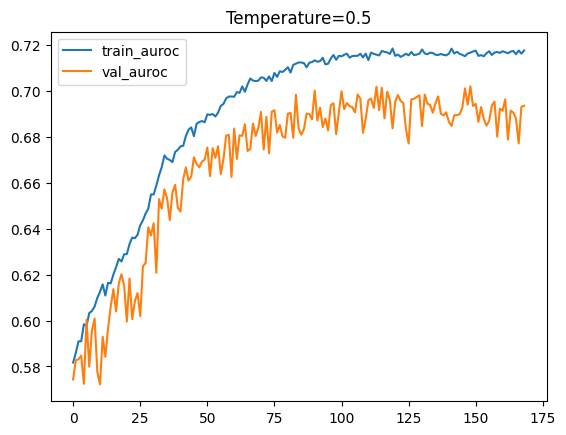

In [36]:
epochs = range(max_epoch+1)

plt.plot(epochs, auroc_train, label='train_auroc')
plt.plot(epochs, auroc_val, label='val_auroc')

plt.title("Temperature=0.5")
plt.legend()
plt.show()

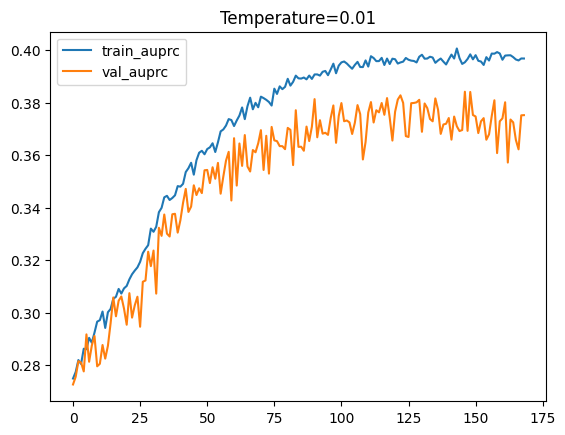

In [37]:
epochs = range(max_epoch+1)

plt.plot(epochs, auprc_train, label='train_auprc')
plt.plot(epochs, auprc_val, label='val_auprc')
plt.title("Temperature=0.01")
plt.legend()
plt.show()

In [36]:
len(tr_feats_img[0])

512

In [1]:
temp = 'SIMCLR-1234_epoch_{epoch:02d}'

In [3]:
temp.split('_epoch')[0]

'SIMCLR-1234'

(array([663., 825., 701., 597., 462., 423., 369., 294., 293., 276., 243.,
        228., 212., 184., 200., 152., 150., 144., 131., 105., 120.,  98.,
         92.,  99.,  75.,  64.,  63.,  62.,  51.,  46.,  46.,  28.,  36.,
         31.,  26.,  19.,  15.,   6.,   8.,   3.,  11.,   7.,   9.,   2.,
          3.,   5.,   0.,   0.,   2.,   1.]),
 array([0.        , 0.04481877, 0.08963755, 0.13445632, 0.17927509,
        0.22409387, 0.26891264, 0.31373141, 0.35855019, 0.40336896,
        0.44818773, 0.49300651, 0.53782528, 0.58264405, 0.62746283,
        0.6722816 , 0.71710037, 0.76191915, 0.80673792, 0.85155669,
        0.89637547, 0.94119424, 0.98601301, 1.03083179, 1.07565056,
        1.12046933, 1.16528811, 1.21010688, 1.25492565, 1.29974442,
        1.3445632 , 1.38938197, 1.43420074, 1.47901952, 1.52383829,
        1.56865706, 1.61347584, 1.65829461, 1.70311338, 1.74793216,
        1.79275093, 1.8375697 , 1.88238848, 1.92720725, 1.97202602,
        2.0168448 , 2.06166357, 2.10648234, 2.

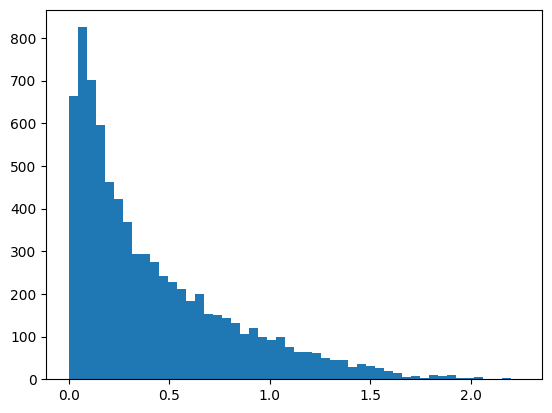

In [38]:
dist = []
for s in tr_feats_img:
    dist = dist + [s[0].sum().item()]
plt.hist(dist, bins=50)

In [89]:
val_feats_ehr[0] # using EVAL 

tensor([ 0.0120,  0.0033,  0.0038,  0.0182, -0.0061, -0.0096, -0.0572, -0.0201,
         0.0084,  0.0078,  0.0025,  0.0111,  0.0122, -0.0035, -0.0081,  0.0067,
         0.0242, -0.0188,  0.0091,  0.0009, -0.0228, -0.0382, -0.0159,  0.0125,
         0.0086, -0.0018,  0.0057, -0.0420,  0.0159, -0.0152,  0.0452,  0.0243,
         0.0340,  0.0341, -0.0137,  0.0328, -0.0686, -0.0403,  0.0032,  0.0148,
        -0.0203,  0.0258,  0.0032,  0.0356, -0.0256, -0.0498, -0.0154, -0.0262,
         0.0171,  0.0228, -0.0264, -0.0038, -0.0293, -0.0583, -0.0180,  0.0051,
         0.0280, -0.0170, -0.0567,  0.0096, -0.0386,  0.0196, -0.0393,  0.0430,
        -0.0048,  0.0032, -0.0184,  0.0113, -0.0470,  0.0506,  0.0244,  0.0132,
        -0.0058, -0.0156,  0.0178,  0.0127,  0.0021, -0.0091, -0.0160,  0.0441,
         0.0370,  0.0262,  0.0281,  0.0472, -0.0484,  0.0014,  0.0052, -0.0011,
        -0.0299, -0.0331, -0.0330, -0.0097,  0.0142,  0.0133,  0.0364,  0.0090,
        -0.0073,  0.0334,  0.0160,  0.05

In [90]:
val_feats_img[0] #usign EVAL 

tensor([ 2.1023e-01,  6.4751e-02, -1.0212e-02, -1.7099e-01, -7.5568e-02,
        -1.6168e-01,  1.3464e-02, -9.7397e-02,  5.0114e-02, -2.3897e-01,
        -6.4518e-02,  2.8434e-01,  7.6330e-02, -5.3734e-02,  6.7631e-02,
        -6.4120e-02,  7.1521e-02, -2.4291e-02, -5.4795e-02,  1.5658e-01,
         7.2187e-02,  2.0795e-02, -6.4179e-02,  3.4936e-01,  1.2700e-02,
        -2.1385e-01,  8.6850e-02, -1.2226e-01,  1.3574e-02, -7.4290e-02,
         2.7795e-02,  1.1540e-01,  2.2109e-01, -2.2681e-02, -1.5513e-01,
         8.3396e-02, -1.6701e-02, -6.4827e-02,  1.0553e-01, -8.1279e-02,
         1.9792e-01,  1.7879e-01,  3.4105e-02, -2.8273e-02,  1.0205e-01,
         6.9246e-03, -1.2693e-01, -1.4577e-01, -2.2922e-01, -1.0756e-01,
        -7.4675e-02,  1.1564e-01, -2.1089e-01, -1.4840e-01, -1.1101e-01,
        -2.7666e-02,  2.5527e-01, -2.1277e-01,  1.4921e-01,  1.0328e-01,
        -3.6980e-02,  1.1430e-01,  1.0152e-01,  4.4733e-01, -2.1519e-01,
        -1.8265e-01, -6.6726e-02,  1.4062e-01, -2.0

In [96]:
val_feats_ehr[0] # using stored during training 

tensor([ 0.0120,  0.0033,  0.0038,  0.0182, -0.0061, -0.0096, -0.0572, -0.0201,
         0.0084,  0.0078,  0.0025,  0.0111,  0.0122, -0.0035, -0.0081,  0.0067,
         0.0242, -0.0188,  0.0091,  0.0009, -0.0228, -0.0382, -0.0159,  0.0125,
         0.0086, -0.0018,  0.0057, -0.0420,  0.0159, -0.0152,  0.0452,  0.0243,
         0.0340,  0.0341, -0.0137,  0.0328, -0.0686, -0.0403,  0.0032,  0.0148,
        -0.0203,  0.0258,  0.0032,  0.0356, -0.0256, -0.0498, -0.0154, -0.0262,
         0.0171,  0.0228, -0.0264, -0.0038, -0.0293, -0.0583, -0.0180,  0.0051,
         0.0280, -0.0170, -0.0567,  0.0096, -0.0386,  0.0196, -0.0393,  0.0430,
        -0.0048,  0.0032, -0.0184,  0.0113, -0.0470,  0.0506,  0.0244,  0.0132,
        -0.0058, -0.0156,  0.0178,  0.0127,  0.0021, -0.0091, -0.0160,  0.0441,
         0.0370,  0.0262,  0.0281,  0.0472, -0.0484,  0.0014,  0.0052, -0.0011,
        -0.0299, -0.0331, -0.0330, -0.0097,  0.0142,  0.0133,  0.0364,  0.0090,
        -0.0073,  0.0334,  0.0160,  0.05

In [97]:
val_feats_img[0] #usign stored during training 

tensor([ 2.1023e-01,  6.4751e-02, -1.0212e-02, -1.7099e-01, -7.5568e-02,
        -1.6168e-01,  1.3464e-02, -9.7397e-02,  5.0114e-02, -2.3897e-01,
        -6.4519e-02,  2.8434e-01,  7.6330e-02, -5.3734e-02,  6.7631e-02,
        -6.4120e-02,  7.1521e-02, -2.4290e-02, -5.4794e-02,  1.5658e-01,
         7.2187e-02,  2.0795e-02, -6.4179e-02,  3.4936e-01,  1.2700e-02,
        -2.1385e-01,  8.6849e-02, -1.2226e-01,  1.3574e-02, -7.4290e-02,
         2.7795e-02,  1.1540e-01,  2.2109e-01, -2.2681e-02, -1.5513e-01,
         8.3396e-02, -1.6702e-02, -6.4827e-02,  1.0553e-01, -8.1279e-02,
         1.9792e-01,  1.7879e-01,  3.4105e-02, -2.8273e-02,  1.0205e-01,
         6.9244e-03, -1.2693e-01, -1.4577e-01, -2.2922e-01, -1.0756e-01,
        -7.4674e-02,  1.1563e-01, -2.1089e-01, -1.4840e-01, -1.1101e-01,
        -2.7666e-02,  2.5527e-01, -2.1277e-01,  1.4921e-01,  1.0328e-01,
        -3.6980e-02,  1.1430e-01,  1.0152e-01,  4.4733e-01, -2.1519e-01,
        -1.8265e-01, -6.6727e-02,  1.4062e-01, -2.0

In [105]:
dummy = '/scratch/fs999/shamoutlab/Farah/contrastive-learning-results/checkpoints/mortality/models'

In [106]:
dummy.replace('mortality', 'phenotyping')

'/scratch/fs999/shamoutlab/Farah/contrastive-learning-results/checkpoints/phenotyping/models'

In [107]:
'in-hospital' == 'in hospital'

False

In [22]:
np.round(0.7131789161327377, 4)

0.7132